# QUORA QUESTION PAIR EDA AND FEATURE EXTRACTION

## Business Problem

### Description  
  
Quora is a platform where people ask questions as well as connect with other people who contribute with their insights and quality solutions.  
As this is a great tool, people who ask questions, expect quick answers. Incase the questions have been repeated mulitple times on quora, then answers to these questions can be retrieved easily.  
For such a scenario, it is important to identify the duplicate questions.  
This project is to predict whether a question on quora has a similar existing question pair.

> Kaggle Project


#### Problem Statement

* Identify which questions asked on Quora are duplicates of questions that have already been asked.  
* This could be useful to instantly provide answers to questions that have already been answered.  
* We are tasked with predicting whether a pair of questions are duplicates or not.  

### Business Objectives and Constraints

1. Cost of misclassification is high  
2. Threshold of choice. 
3. NO strict latency concerns
4. Interpretability is partially important

## Machine Learning Problem

* Binary Classification problem - We need to predict if questions are duplicate or not

1. Performance Metric  
    * log loss  
    * Binary confusion matrix
2. Train-Test Construction
    * Train and test will be built from the dataset by splitting it in 80:20 ratio.

## Exploratory Data Analysis

In [93]:
#Data handling libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

#Interact with the underlying operating system
import os
from os import path

#Underlying memory management mechanism
import gc

#NLP libraries
import re
import nltk
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### 1. Reading data and checking details

In [3]:
data = pd.read_csv('data.csv')
print('Shape : ',data.shape)

Shape :  (404290, 6)


In [4]:
#checking first 5 rows of data
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#checking feature information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Data Information**  
   
* id : row identifier  
* qid1 : Question 1 identifier   
* qid2 : Question 2 identifier  
* question1 : first question content  
* question2 : second question content  
* is_duplicate : Target Variable indicating if two questions are duplicate or not  

**NOTE : There are total 404,290 records, but question1 has 1 missing value and question2 has 2 missing values**

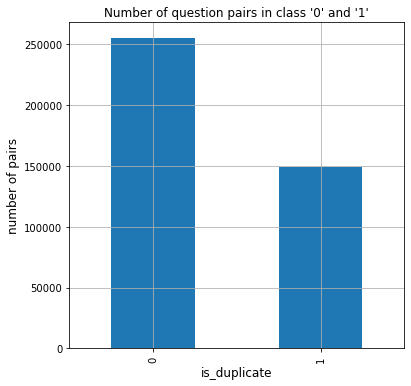

In [9]:
#Data distribution based on target variable
plt.figure(figsize=(6,6))
data.groupby('is_duplicate')['id'].count().plot.bar()
plt.title('Number of question pairs in class \'0\' and \'1\'')
plt.xlabel('is_duplicate', fontsize=12)
plt.ylabel('number of pairs', fontsize=12)
plt.grid(1)
plt.show()

In [25]:
print('Total question pairs : ', len(data))
print('Non-duplicate question pairs : ',len(data[data['is_duplicate']==0]))
print('Distribution : Non-duplicate are {}'.format(round(len(data[data['is_duplicate']==0])/len(data)*100,2)))
print('Distribution : Duplicate are {}'.format(round(len(data[data['is_duplicate']==1])/len(data)*100,2)))
print('Duplicate question pairs : ',len(data[data['is_duplicate']==1]))

Total question pairs :  404290
Non-duplicate question pairs :  255027
Distribution : Non-duplicate are 63.08
Distribution : Duplicate are 36.92
Duplicate question pairs :  149263


In [26]:
#finding number of unique questions
questions = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_ones = len(np.unique(questions))
duplicate_ques_count = np.sum(questions.value_counts()>1)
print('Total questions qid1 plus qid2 : ', len(questions))
print('Unique questions : ', unique_ones)
print('Count of questions that are having duplicates : ', duplicate_ques_count)

Total questions qid1 plus qid2 :  808580
Unique questions :  537933
Count of questions that are having duplicates :  111780


In [29]:
print('Max count of single question being repeated : ',max(questions.value_counts()))

Max count of single question being repeated :  157


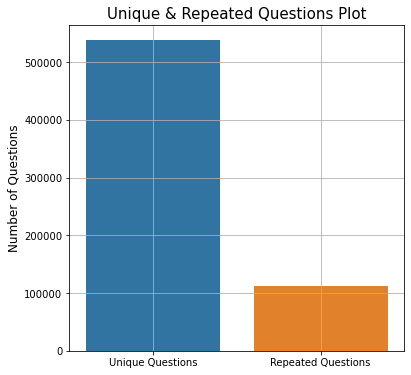

In [30]:
#Number of Unique and Repeated question plot
x = ['Unique Questions' , 'Repeated Questions']
y = [unique_ones, duplicate_ques_count]
plt.figure(figsize=(6,6))
sns.barplot(x,y)
plt.title('Unique & Repeated Questions Plot',fontsize=15)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(1)
plt.show()

In [32]:
#checking for duplicate pairs
print('Number of duplicate pairs are : ', data.duplicated(['qid1','qid2']).sum())

Number of duplicate pairs are :  0


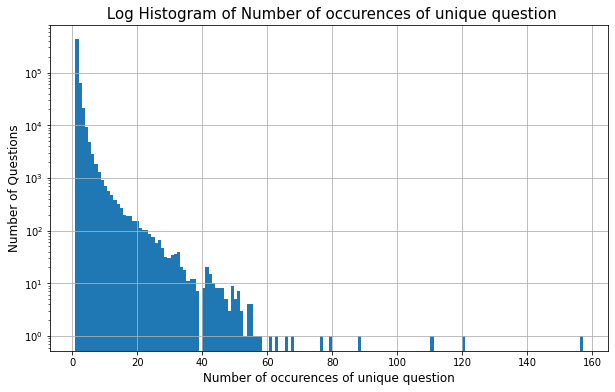

In [46]:
#Number of occurances of each question
plt.figure(figsize=(10,6))
plt.hist(questions.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')
plt.title(' Log Histogram of Number of occurences of unique question',fontsize=15)
plt.xlabel('Number of occurences of unique question', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(1)
plt.show()

In [48]:
#null value checking
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [52]:
data[data.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [53]:
#dropping null values
data.dropna(how='any',axis=0,inplace=True)

In [54]:
data.shape

(404287, 6)

### 2. Basic Feature Extraction

In [57]:
def basic_feature_extraction(rec):
    features = [0]*9
    qid1_len = len(rec['question1'])
    qid2_len = len(rec['question2'])
    qid1_words = len(rec['question1'].split(" "))
    qid2_words = len(rec['question2'].split(" "))
    qid1_word = set(map(lambda word: word.lower().strip(), rec['question1'].split(" ")))
    qid2_word = set(map(lambda word: word.lower().strip(), rec['question2'].split(" ")))
    
    q1 = rec['question1'].lower().replace('?','').replace('.','').replace('!','')
    q2 = rec['question2'].lower().replace('?','').replace('.','').replace('!','')
    row_words = list(set(q1.split(' ') + q2.split(' ')))
    q1_vec, q2_vec = np.zeros((1,len(row_words))), np.zeros((1,len(row_words)))
    
    for word in q1.split(' '):
        q1_vec[0][row_words.index(word)]+=1
    for word in q2.split(' '):
        q2_vec[0][row_words.index(word)]+=1
        
    features[0] = qid1_len
    features[1] = qid2_len
    features[2] = qid1_words
    features[3] = qid2_words
    features[4] = 1.0 * len(qid1_word & qid2_word)
    features[5] = 1.0 * (len(qid2_word) + len(qid2_word))
    features[6] = 1.0 * len(qid1_word & qid2_word) / (len(qid2_word) + len(qid2_word))
    features[7] = np.linalg.norm(q1_vec - q2_vec)
    features[8] = (1 - np.matmul(q1_vec, q2_vec.T)/(np.linalg.norm(q1_vec) * np.linalg.norm(q2_vec)))[0][0]
    
    return features

In [58]:
basic_features = data.apply(basic_feature_extraction, axis=1)
basic_features_names = ['qid1_len', 'qid2_len', 'qid1_words', 'qid2_words', 'common_word', 
                       'total_word', 'word_share', 'eucl_dist', 'cos_dist']
for i, name in enumerate(basic_features_names):
    data[name] = list(map(lambda x:x[i], basic_features))
data.shape

(404287, 15)

In [59]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,qid1_len,qid2_len,qid1_words,qid2_words,common_word,total_word,word_share,eucl_dist,cos_dist
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,22.0,0.454545,1.414214,0.055089
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,24.0,0.166667,3.316625,0.452277
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4.0,20.0,0.200000,4.000000,0.661938
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.0,18.0,0.000000,4.690416,1.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2.0,14.0,0.142857,3.741657,0.685515


**FEATURES CREATED**  
1. qid1_len    : length of question 1  
2. qid2_len    : length of question 2
3. qid1_words  : Number of words in question 1  
4. qid2_words  : Number of words in question 2
5. common_word : Number of common words in question 1 and 2  
6. total_word  : Total words (combined question 1 and question 2)  
7. word_share  : Share of common words among total words  
8. eucl_dist   : Euclidean distance between question 1 and question 2  
9. cos_dist    : Cosine distance between question 1 and question 2  

### 3. Analysing basic extracted features

In [61]:
print('Minimum words in question 1 : ', min(data['qid1_words']))
print('Minimum words in question 2 : ', min(data['qid2_words']))

Minimum words in question 1 :  1
Minimum words in question 2 :  1


In [62]:
print('Number of questions with one word in question 1 : ',data[data['qid1_words']==1].shape[0])
print('Number of questions with one word in question 2 : ',data[data['qid2_words']==1].shape[0])

Number of questions with one word in question 1 :  66
Number of questions with one word in question 2 :  22


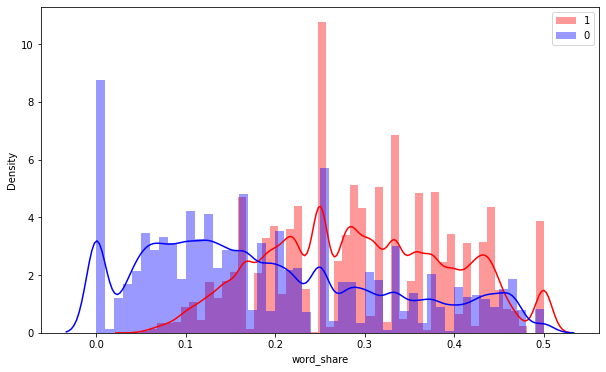

In [64]:
plt.figure(figsize=(10,6))
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:], label = '1', color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:], label = '0', color = 'blue')
plt.legend()
plt.show()

* The distribution of word_share has overlap on the right side indicating there are quite a lot of questions with high word similarity  
* More number of common words are present when question 1 and question 2 are duplicate

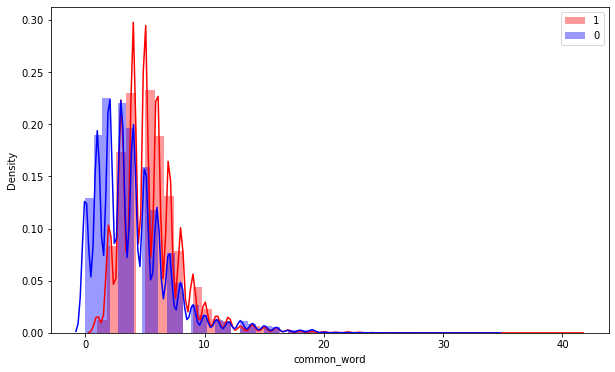

In [65]:
plt.figure(figsize=(10,6))
sns.distplot(data[data['is_duplicate'] == 1.0]['common_word'][0:], label = '1', color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['common_word'][0:], label = '0', color = 'blue')
plt.legend()
plt.show()

* High overlap for number of common unique words between duplicate and non-duplicate questions

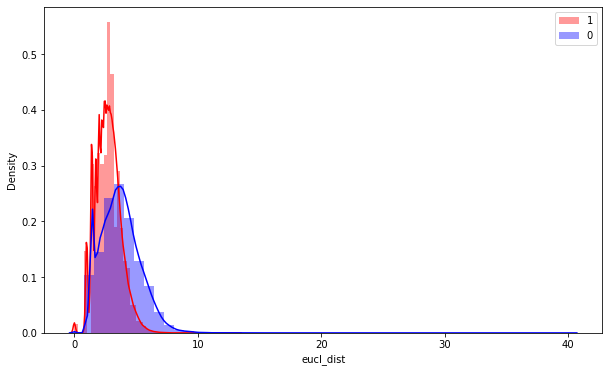

In [66]:
plt.figure(figsize=(10,6))
sns.distplot(data[data['is_duplicate'] == 1.0]['eucl_dist'][0:], label = '1', color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['eucl_dist'][0:], label = '0', color = 'blue')
plt.legend()
plt.show()

* Few overlapping and few non-overlapping euclidean distance for duplicate and non-duplicate questions

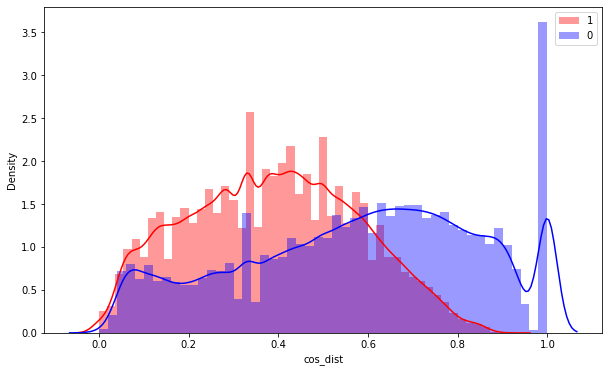

In [67]:
plt.figure(figsize=(10,6))
sns.distplot(data[data['is_duplicate'] == 1.0]['cos_dist'][0:], label = '1', color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['cos_dist'][0:], label = '0', color = 'blue')
plt.legend()
plt.show()

* More overlapping on the left side. Non-duplicate questions have higher value of cosine distance

### 4. Advanced Feature Extraction

In [71]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubham/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Preprocessing

In [72]:
def text_preprocess(x):
    porter = PorterStemmer()
    x = str(x).lower()
    x.replace(",000,000","m").replace(",000","k").replace("′", "'").replace("’", "'")\
                    .replace("won't","will not").replace("cannot", "can not").replace("can't", "can not")\
                    .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                    .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                    .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                    .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                    .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m",x)
    x = re.sub(r"([0-9]+)000", r"\1k",x)
    x = re.sub(r'<.*?>','',x)
    x = porter.stem(x)
    return x

In [73]:
SAFE_DIV = 0.0001 # To get results in four decimal points
STOP_WORDS = stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0]*10
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_stop_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_stop_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

**TOKEN : Obtained by splitting string with space.**  
**STOP_WORD : Common words in any language - here as per NLTK.**   
**WORD : A token which is not a stopword.**  
  
**TOKEN FEATURES CREATED :**  

1. cwc_min : ratio of common word count to minimum length among word count of q1 and q2  
2. cwc_max : ratio of common word count to maximium length among word count of q1 and q2  
3. csc_min : ratio of common stop word count to minimum length among stop word count of q1 and q2  
4. csc_max : ratio of common stop word count to maximum length among stop word count of q1 and q2  
5. ctc_min : ratio of common token count to minimum length among token count of q1 and q2  
6. ctc_max : ratio of common token count to maximum length among token count of q1 and q2  
7. last_word_eq : If last word of both questions is same or not  
8. first_word_eq : If first word of both questions is same or not  
9. abs_len_diff : abs length difference of tokens in q1 and q2  
10. mean_len : average token length of both questions  

In [74]:
def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a),len(b)) + 1)

In [78]:
def extract_features(df):
    
    basic_features = df.apply(basic_feature_extraction, axis=1)
    basic_features_names = ['qid1_len', 'qid2_len', 'qid1_words', 'qid2_words', 'common_word', 
                       'total_word', 'word_share', 'eucl_dist', 'cos_dist']
    for i, name in enumerate(basic_features_names):
        df[name] = list(map(lambda x:x[i], basic_features))
        
    df['question1'] = df['question1'].apply(text_preprocess)
    df['question2'] = df['question2'].apply(text_preprocess)
    
    token_features = df.apply(lambda x:get_token_features(x['question1'], x['question2']), axis=1)
    new_cols = ['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq',
               'abs_len_diff','mean_len']
    for i, name in enumerate(new_cols):
        df[name] = list(map(lambda x:x[i], token_features))
        
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']), axis=1)
    df['fuzz_ratio'] = df.apply(lambda x:fuzz.QRatio(x['question1'],x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x:fuzz.partial_ratio(x['question1'],x['question2']), axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'],x['question2']), axis=1)
    
    return df

In [81]:
if os.path.isfile('extracted_features.csv'):
    df = pd.read_csv('extracted_features.csv', encoding = 'latin-1')
    print('Shape of extracted features: ',df.shape)
else:
    df = pd.read_csv('data.csv')
    df.dropna(axis=0,how='any',inplace=True)
    df = extract_features(df)
    df.to_csv('extracted_features.csv', index=False)
    print('Shape of data after extracting features: ',df.shape)
df.head(2)    

Shape of data after extracting features:  (404287, 30)


,id,qid1,qid2,question1,question2,is_duplicate,qid1_len,qid2_len,qid1_words,qid2_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,0.428568,0,1,2,13.0,100,93,93,98,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,0.153845,0,1,5,10.5,86,63,66,75,0.576923


### 5. Analysis of Advanced extracted features

In [82]:
data_duplicate = df[df['is_duplicate']==1]
data_nonduplicate = df[df['is_duplicate']==0]

p = np.dstack([data_duplicate["question1"], data_duplicate["question2"]]).flatten()
n = np.dstack([data_nonduplicate["question1"], data_nonduplicate["question2"]]).flatten()

p = ' '.join(p)
n = ' '.join(n)

print('total length of string in duplicate pair including all : ',len(p))
print('total length of string in nonduplicate pair including all : ',len(n))

total length of string in duplicate pair including all :  16067654
total length of string in nonduplicate pair including all :  33084842


In [83]:
#adding more stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.add("not")
stopwords.add("no")
stopwords.add("like")

**Wordcloud for duplicate pair**

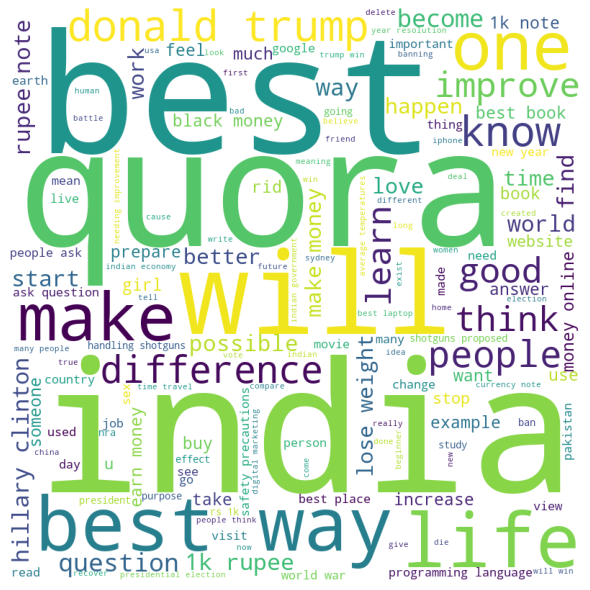

In [84]:
wordcloud = WordCloudloud(width=800, height=800,
                     background_color = 'white',
                     stopwords=stopwords,
                     min_font_size = 10).generate(p)
plt.figure(figsize=(12,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Wordcloud for non-duplicate pairs**

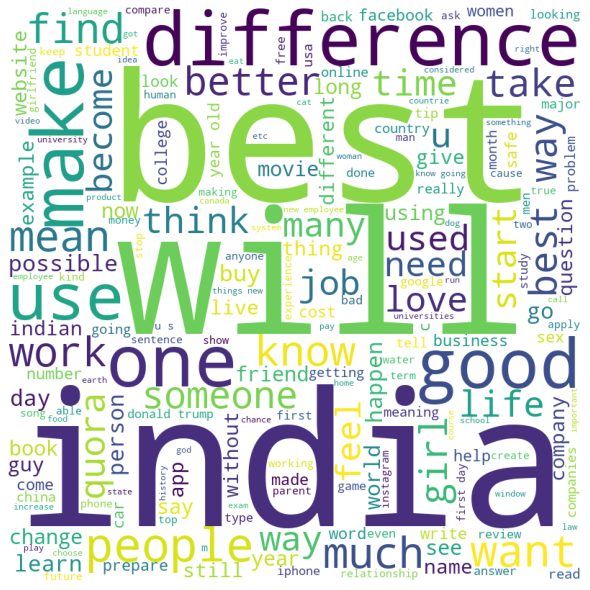

In [85]:
wordcloud = WordCloud(width=800, height=800,
                     background_color = 'white',
                     stopwords=stopwords,
                     min_font_size = 10).generate(n)
plt.figure(figsize=(12,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

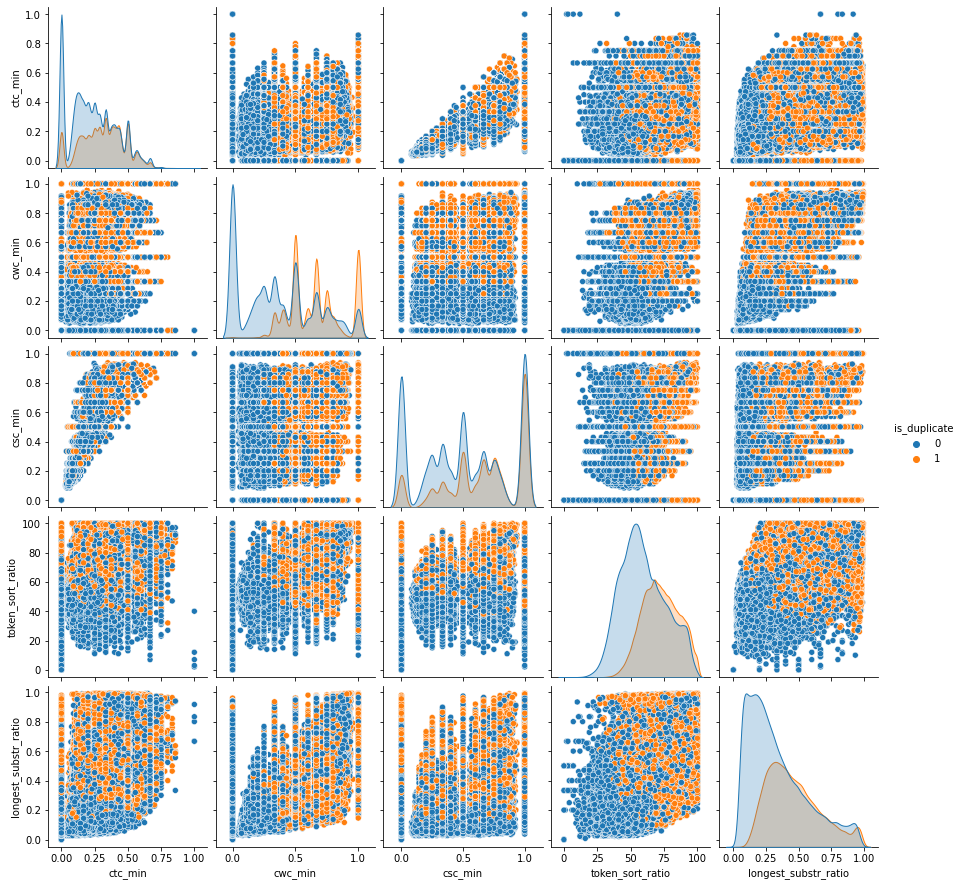

In [87]:
#pair plot of features : ctc_min, cwc_min, csc_min, token_sort_ratio, longest_substr_ratio
n = df.shape[0]
sns.pairplot(df[['ctc_min','cwc_min','csc_min','token_sort_ratio','longest_substr_ratio','is_duplicate']][0:n]
            ,hue='is_duplicate',vars=['ctc_min','cwc_min','csc_min','token_sort_ratio','longest_substr_ratio'])
plt.show()

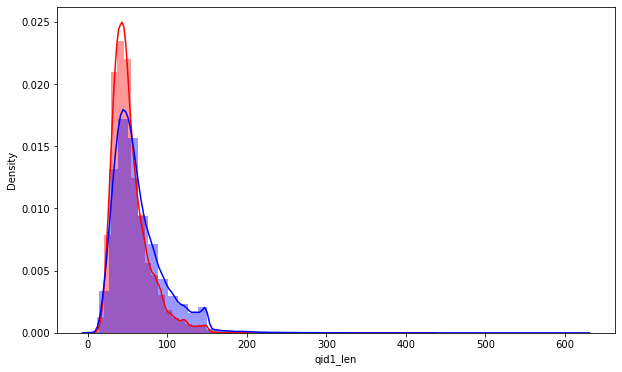

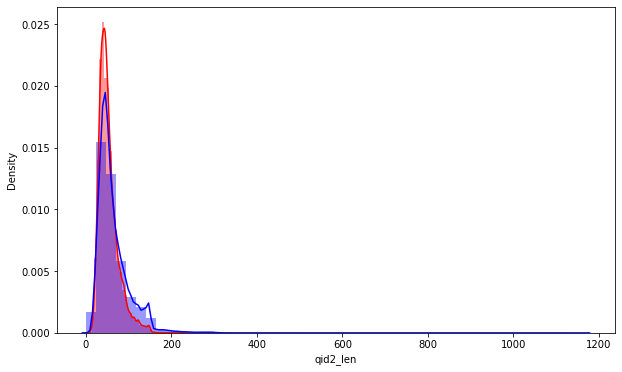

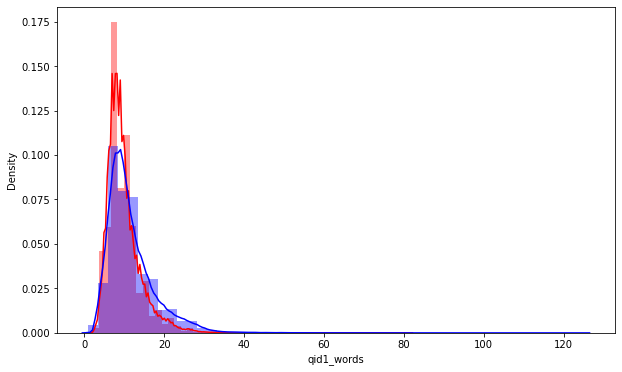

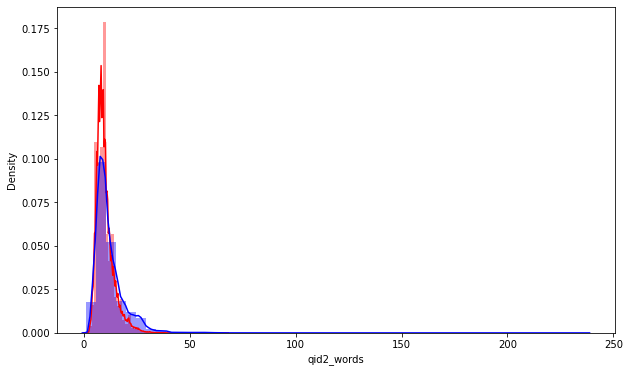

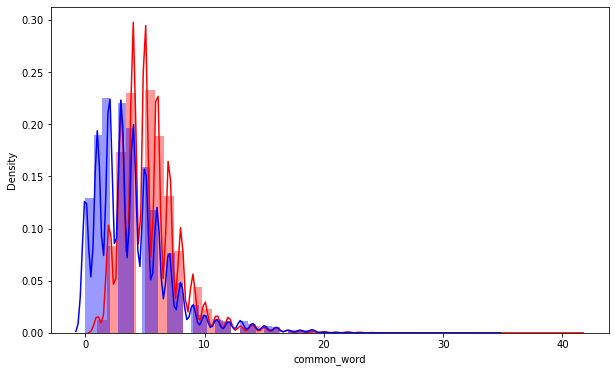

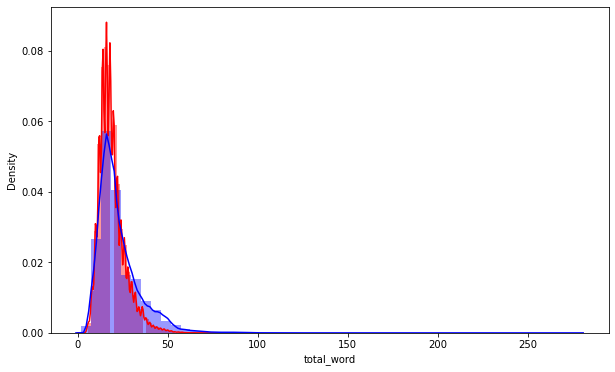

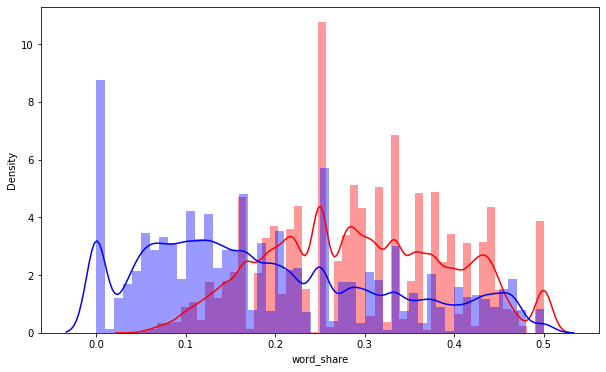

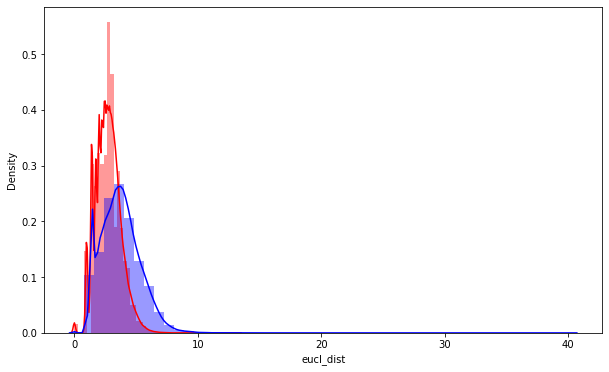

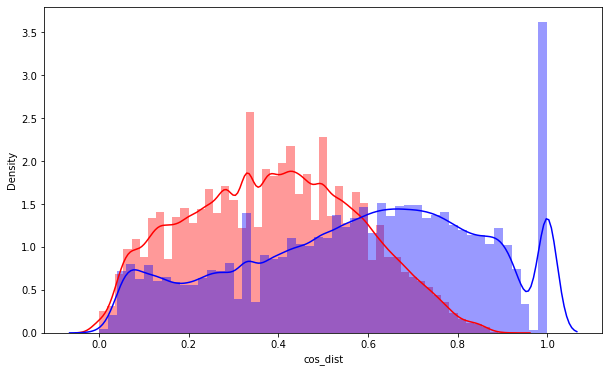

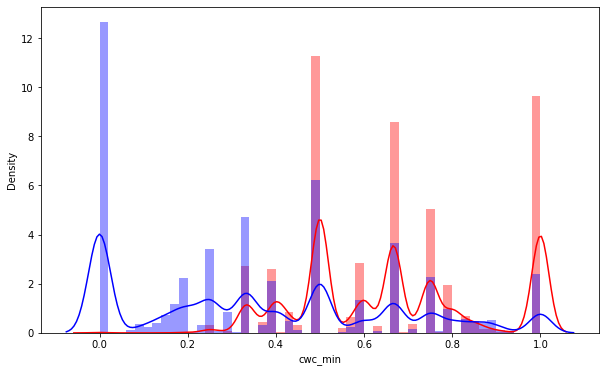

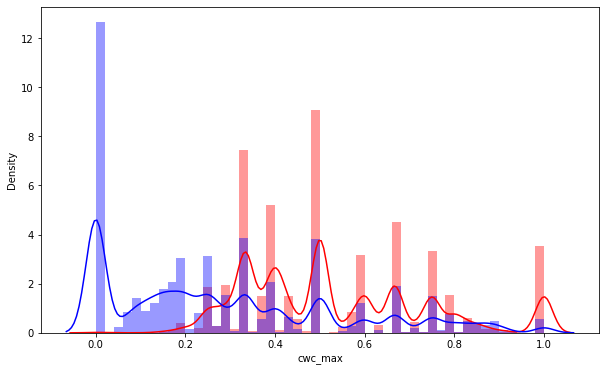

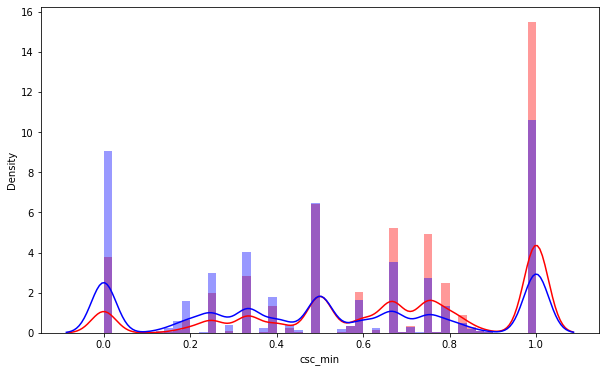

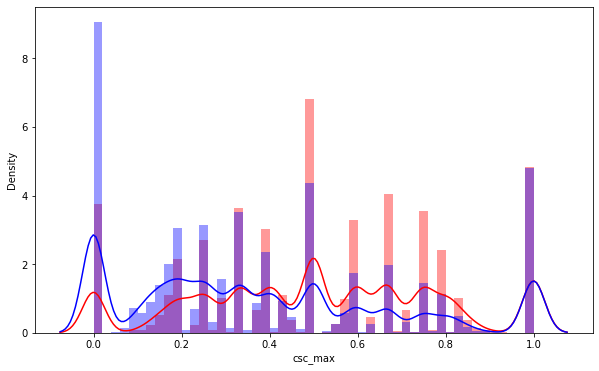

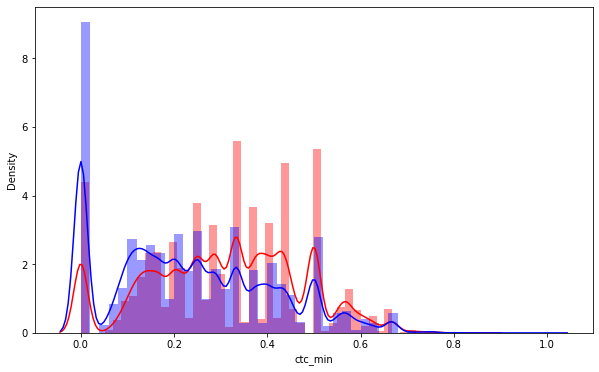

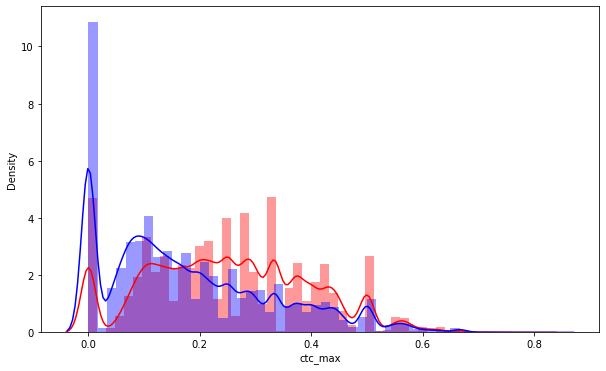

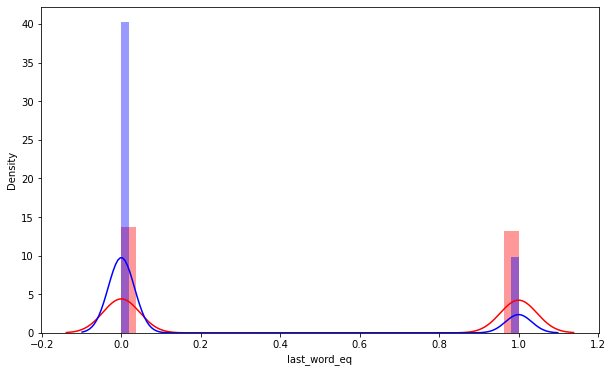

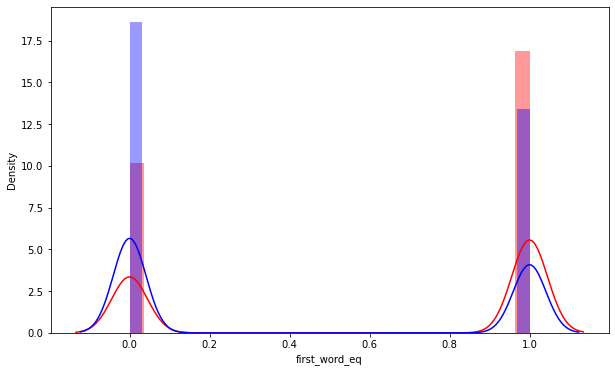

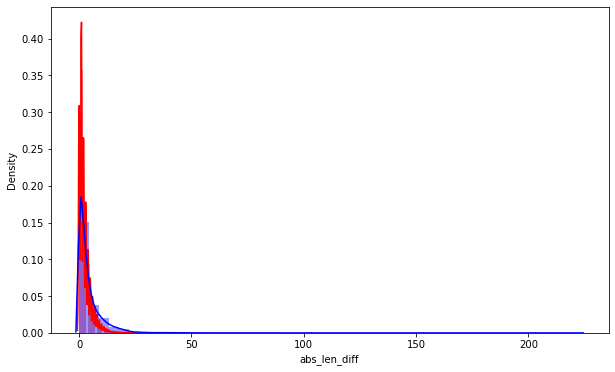

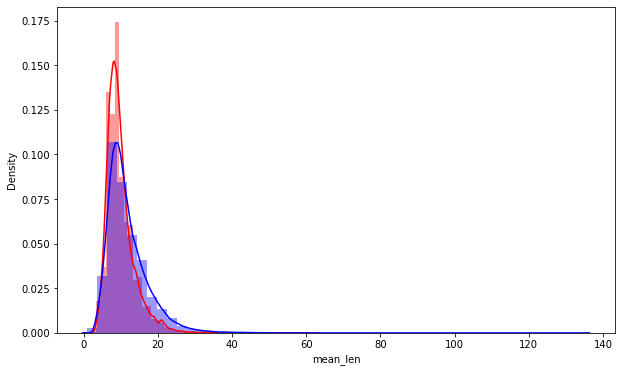

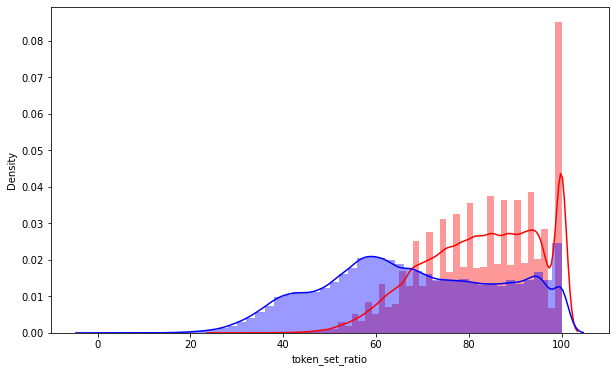

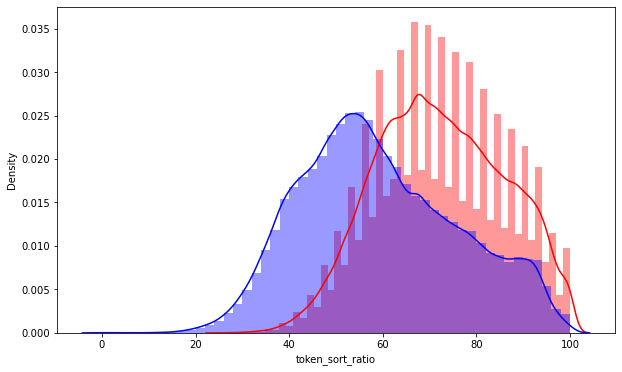

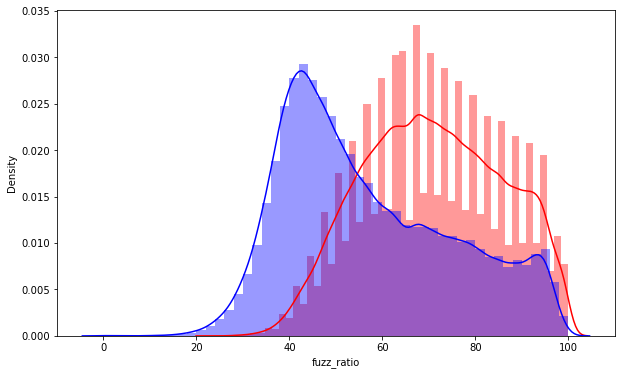

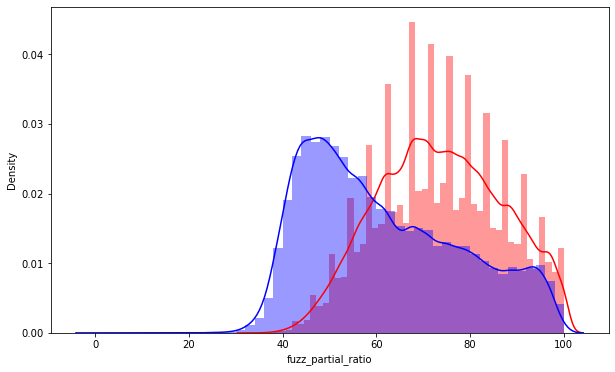

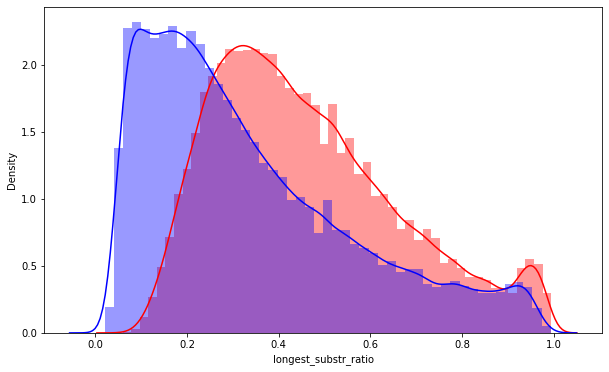

In [92]:

cols = ['id','qid1','qid2','question1','question2','is_duplicate']
cols = [col for col in df.columns if col not in cols]
for col in cols:
    plt.figure(figsize=(10,6))
    sns.distplot(df[df['is_duplicate']==1.0][col][0:], label='1', color='red')
    sns.distplot(df[df['is_duplicate']==0.0][col][0:], label='1', color='blue')
    plt.show()

In [94]:
df_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
            'last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio',
            'fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']])
y = df_subsampled['is_duplicate'].values

Text(0.5, 1.0, 'perplexity 10\n n_iteration = 1000')

Text(0.5, 1.0, 'perplexity 30\n n_iteration = 1000')

Text(0.5, 1.0, 'perplexity 50\n n_iteration = 1000')

Text(0.5, 1.0, 'perplexity 10\n n_iteration = 3000')

Text(0.5, 1.0, 'perplexity 30\n n_iteration = 3000')

Text(0.5, 1.0, 'perplexity 50\n n_iteration = 3000')

Text(0.5, 1.0, 'perplexity 10\n n_iteration = 5000')

Text(0.5, 1.0, 'perplexity 30\n n_iteration = 5000')

Text(0.5, 1.0, 'perplexity 50\n n_iteration = 5000')

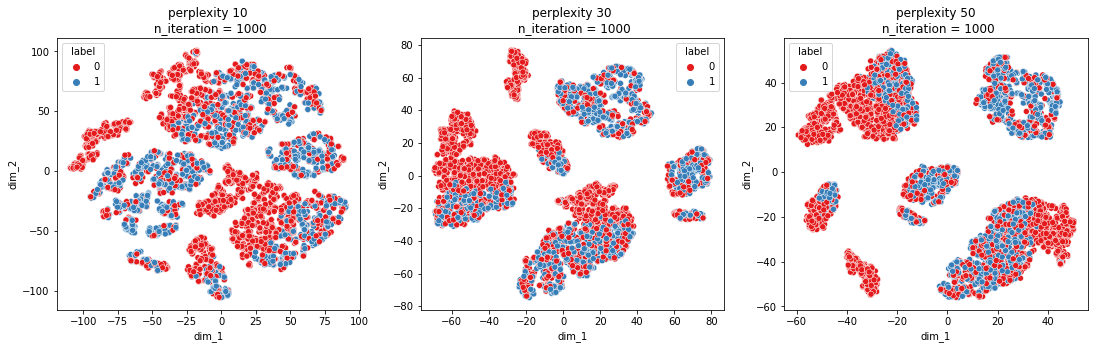

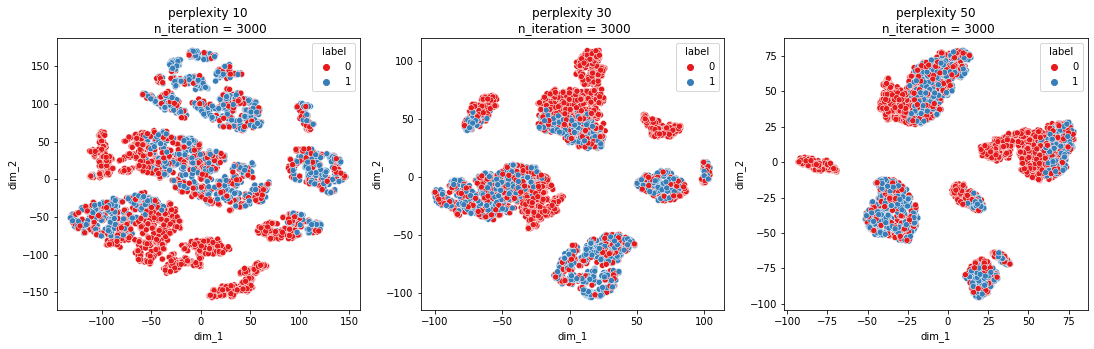

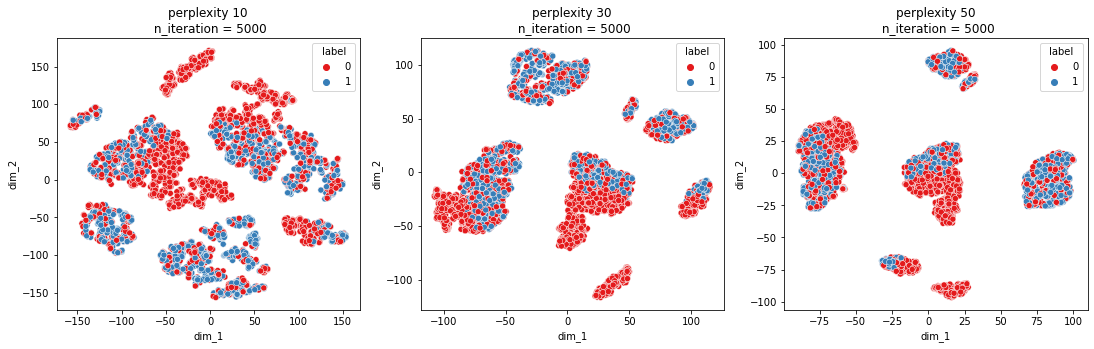

In [95]:
def TSNE_data(p,n):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=n).fit_transform(X)
    df = pd.DataFrame({'dim_1':tsne[:,0],'dim_2':tsne[:,1],'label':y})
    return df

iterations = [1000,3000,5000]
perplexities = [10,30,50]

for n in iterations:
    fig = plt.figure(figsize=(25,5))
    for i, p in enumerate(perplexities):
        data = TSNE_data(p,n)
        ax = fig.add_subplot(1,4,i+1)
        ax = sns.scatterplot(data=data, x='dim_1', y='dim_2', hue='label',palette='Set1',
                            markers=['s','o'])
        plt.title('perplexity {}\n n_iteration = {}'.format(p,n))

* By looking at multiptle t-SNE plot we can say that with advanced designed feature there are some regions where one are grouped together. So we can say that these designed features will be helpful in classifying the class whether a given pair of question is dulicate or not.